In [1]:
conda install -c conda-forge caiman

2 channel Terms of Service accepted
Retrieving notices: done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 25.5.1
  latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.11.1



## Package Plan ##

  environment location: /opt/anaconda3/envs/calcium_imaging_cli

  added / updated specs:
    - caiman


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2026.1.4   |       hbd8a1cb_0         143 KB  conda-forge
    certifi-2026.1.4           |     pyhd8ed1ab_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         291 KB

The following packages will be UPDATED:

  ca-certificates         

In [2]:
import caiman as cm
from caiman.motion_correction import MotionCorrect

cm.__version__

'1.11.0'

In [3]:
import os
import h5py
import numpy as np
from skimage.io import imsave
from pathlib import Path

def convert_ims_to_tiff(
    ims_path,
    out_tiff=None,
    res_level=0,
    timepoint=0,
    channel=0,
    bigtiff=True
):
    """
    Convert an Imaris .ims file to a TIFF stack for CaImAn.

    Parameters
    ----------
    ims_path : str or Path
        Path to the .ims file.
    out_tiff : str or Path, optional
        Output .tif path. If None, uses ims_path with .tif extension.
    res_level : int
        Resolution level index (0 is full res).
    timepoint : int
        Time point index (0 for first timepoint).
    channel : int
        Channel index (0-based).
    bigtiff : bool
        Whether to write as BigTIFF (recommended for large stacks).

    Returns
    -------
    out_tiff : Path
        Path to the written TIFF file.
    """

    ims_path = Path(ims_path)
    if ims_path.suffix.lower() != ".ims":
        raise TypeError(f"Input must be a .ims file, got {ims_path}")

    if out_tiff is None:
        out_tiff = ims_path.with_suffix(".tif")
    else:
        out_tiff = Path(out_tiff)

    print(f"[convert_ims_to_tiff] Reading {ims_path}")

    with h5py.File(ims_path, "r") as f:
        # This matches the structure in your script:
        # DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data
        ds = f["DataSet"]
        res_group = ds[f"ResolutionLevel {res_level}"]
        tp_group = res_group[f"TimePoint {timepoint}"]
        ch_group = tp_group[f"Channel {channel}"]
        data = ch_group["Data"]

        # Load into memory as a NumPy array
        stack = np.array(data)

    print(f"[convert_ims_to_tiff] Stack shape: {stack.shape}")
    print(f"[convert_ims_to_tiff] Writing {out_tiff}")
    imsave(str(out_tiff), stack, bigtiff=bigtiff)

    print("[convert_ims_to_tiff] Done.")
    return out_tiff

In [4]:
ims_file = '/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.ims'  # <-- point this at your actual file
tif_file = convert_ims_to_tiff(ims_file)
tif_file

[convert_ims_to_tiff] Reading /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.ims
[convert_ims_to_tiff] Stack shape: (1, 512, 512)
[convert_ims_to_tiff] Writing /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.tif
[convert_ims_to_tiff] Done.


/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_28454/3222013170.py:64: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imsave`.
  imsave(str(out_tiff), stack, bigtiff=bigtiff)
/opt/anaconda3/envs/calcium_imaging_cli/lib/python3.11/site-packages/skimage/_shared/utils.py:328: UserWarning: /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.tif is a low contrast image
  return func(*args, **kwargs)


PosixPath('/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.tif')

In [5]:
import os
import h5py
import numpy as np
from pathlib import Path
import tifffile as tiff  # avoids the skimage FutureWarning

def convert_ims_movie_to_tiff(
    ims_path,
    out_tiff=None,
    res_level=0,
    channel=0,
    collapse_z=True,
    bigtiff=True,
):
    """
    Convert an Imaris .ims *movie* (multiple TimePoints) into a TIFF stack
    suitable for CaImAn (T, Y, X).

    Parameters
    ----------
    ims_path : str or Path
        Path to the .ims file.
    out_tiff : str or Path, optional
        Output .tif path. If None, uses ims_path with .tif extension.
    res_level : int
        Resolution level index (0 = full res).
    channel : int
        0-based channel index to read (e.g., 0 = green, 1 = red, etc.).
    collapse_z : bool
        If True, collapse Z to 2D (for each timepoint). If Z>1, uses max
        projection across Z. If Z==1, just squeezes that dimension.
    bigtiff : bool
        Write as BigTIFF (recommended for large movies).

    Returns
    -------
    out_tiff : Path
        Path to the written TIFF file.
    """

    ims_path = Path(ims_path)
    if ims_path.suffix.lower() != ".ims":
        raise TypeError(f"Input must be a .ims file, got {ims_path}")

    if out_tiff is None:
        out_tiff = ims_path.with_suffix(".tif")
    else:
        out_tiff = Path(out_tiff)

    print(f"[convert_ims_movie_to_tiff] Reading {ims_path}")

    frames = []
    with h5py.File(ims_path, "r") as f:
        ds = f["DataSet"]
        res_group = ds[f"ResolutionLevel {res_level}"]

        # Find all timepoints: keys like "TimePoint 0", "TimePoint 1", ...
        tp_keys = [k for k in res_group.keys() if k.startswith("TimePoint ")]
        tp_keys = sorted(tp_keys, key=lambda k: int(k.split(" ")[1]))
        print(f"[convert_ims_movie_to_tiff] Found {len(tp_keys)} timepoints")

        for k in tp_keys:
            tp_group = res_group[k]
            ch_group = tp_group[f"Channel {channel}"]
            data = ch_group["Data"][()]  # typically (Z, Y, X)

            if data.ndim == 3:
                z, y, x = data.shape
                if collapse_z:
                    if z == 1:
                        frame = data[0]
                    else:
                        frame = data.max(axis=0)  # max over Z
                else:
                    # keep Z as extra dimension if you really want (Z,Y,X)
                    # CaImAn expects (T,Y,X), so collapse_z=True is recommended
                    frame = data
            elif data.ndim == 2:
                frame = data
            else:
                raise ValueError(
                    f"Unexpected data shape for {k}/Channel {channel}: {data.shape}"
                )

            frames.append(frame)

    stack = np.stack(frames, axis=0)  # (T, Y, X)
    print(f"[convert_ims_movie_to_tiff] Stack shape (T, Y, X): {stack.shape}")
    print(f"[convert_ims_movie_to_tiff] Writing {out_tiff}")

    # Write as float32 or uint16 depending on data; here we just preserve dtype
    tiff.imwrite(str(out_tiff), stack, bigtiff=bigtiff)
    print("[convert_ims_movie_to_tiff] Done.")

    return out_tiff

In [6]:
ims_file = "/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.ims"

tif_movie = convert_ims_movie_to_tiff(
    ims_file,
    channel=0,          # adjust if green is not channel 0
    collapse_z=True     # good for 2D+T CaImAn
)

tif_movie

[convert_ims_movie_to_tiff] Reading /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.ims
[convert_ims_movie_to_tiff] Found 1000 timepoints
[convert_ims_movie_to_tiff] Stack shape (T, Y, X): (1000, 512, 512)
[convert_ims_movie_to_tiff] Writing /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.tif
[convert_ims_movie_to_tiff] Done.


PosixPath('/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2.tif')

In [7]:
import caiman as cm
from caiman.motion_correction import MotionCorrect
import numpy as np
import tifffile as tiff
from pathlib import Path

def motion_correct_tiff_for_organoid(
    tiff_path,
    pw_rigid=True,
    max_shifts=(12, 12),
    strides=(48, 48),
    overlaps=(24, 24),
    gSig_filt=(3, 3),
):
    fn = [str(tiff_path)]
    is_3D = False  # this is now a (T, Y, X) movie

    mc = MotionCorrect(
        fn,
        min_mov=None,
        max_shifts=max_shifts,
        strides=strides,
        overlaps=overlaps,
        pw_rigid=pw_rigid,
        is3D=is_3D,
        gSig_filt=gSig_filt,
    )
    mc.motion_correct(save_movie=True)

    corrected_file = mc.fname_tot_els[0] if pw_rigid else mc.fname_tot_rig[0]
    print(f"[motion_correct] Corrected movie: {corrected_file}")

    # time-average projection for ROI drawing
    m_corr = cm.load(corrected_file)
    avg = np.mean(m_corr, axis=0)

    avg_path = Path(corrected_file).with_suffix("").with_name(
        Path(corrected_file).stem + "_avg.tif"
    )
    tiff.imwrite(str(avg_path), avg.astype("float32"))
    print(f"[motion_correct] Saved average projection: {avg_path}")

    return corrected_file, avg_path

In [8]:
corrected_tif, avg_tif = motion_correct_tiff_for_organoid(tif_movie)
corrected_tif, avg_tif

/opt/anaconda3/envs/calcium_imaging_cli/lib/python3.11/site-packages/caiman/motion_correction.py:3081: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


[motion_correct] Corrected movie: /Users/ecrespo/caiman_data/temp/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_els__d1_512_d2_512_d3_1_order_F_frames_1000.mmap
[motion_correct] Saved average projection: /Users/ecrespo/caiman_data/temp/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_els__d1_512_d2_512_d3_1_order_F_frames_1000_avg.tif


('/Users/ecrespo/caiman_data/temp/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_els__d1_512_d2_512_d3_1_order_F_frames_1000.mmap',
 PosixPath('/Users/ecrespo/caiman_data/temp/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_els__d1_512_d2_512_d3_1_order_F_frames_1000_avg.tif'))

In [9]:
raw_path = tif_movie          # or a string path: "/path/to/raw.tif"
mc_path  = corrected_tif      # or "/path/to/corrected.tif"

raw_movie = cm.load(str(raw_path))   # shape: (T, Y, X)
mc_movie  = cm.load(str(mc_path))

raw_movie.shape, mc_movie.shape

((1000, 512, 512), (1000, 512, 512))

In [10]:
# You might already have ipywidgets; if not, this installs it.
# If you get an error, just pip install from the terminal in this env.
try:
    import ipywidgets as widgets
except ImportError:
    !pip install ipywidgets
    import ipywidgets as widgets

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [11]:
!pip install ipympl

In [12]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import IntSlider, Play, Dropdown
from IPython.display import display

# ---------------------------------------------
# Robust contrast scaling per movie
# ---------------------------------------------
raw_p1, raw_p99 = np.percentile(raw_movie, [1, 99])
mc_p1,  mc_p99  = np.percentile(mc_movie,  [1, 99])

n_frames = raw_movie.shape[0]

def show_frame(frame, cmap_raw='gray', cmap_mc='gray'):
    """Redraws the whole figure for the given frame and colormaps."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # RAW
    raw_norm = np.clip((raw_movie[frame] - raw_p1) / (raw_p99 - raw_p1 + 1e-9), 0, 1)
    im1 = axes[0].imshow(raw_norm, cmap=cmap_raw)
    axes[0].set_title(f"RAW (frame {frame})")
    axes[0].axis("off")
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # MC
    mc_norm = np.clip((mc_movie[frame] - mc_p1) / (mc_p99 - mc_p1 + 1e-9), 0, 1)
    im2 = axes[1].imshow(mc_norm, cmap=cmap_mc)
    axes[1].set_title(f"Motion-corrected (frame {frame})")
    axes[1].axis("off")
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    fig.tight_layout()
    plt.show()

# ---------------------------------------------
# Widgets: play, slider, colormaps
# ---------------------------------------------
play = Play(
    value=0,
    min=0,
    max=n_frames - 1,
    step=1,
    interval=80,   # ms between frames; increase if too fast
    description="Press play",
    disabled=False,
)

slider = IntSlider(
    min=0,
    max=n_frames - 1,
    step=1,
    value=0,
    description="frame",
)

# link play and slider
widgets.jslink((play, 'value'), (slider, 'value'))

cmap_options = ['gray', 'magma', 'inferno', 'viridis', 'plasma']

cmap_raw_dd = Dropdown(
    options=cmap_options,
    value='gray',
    description='RAW cmap',
)

cmap_mc_dd = Dropdown(
    options=cmap_options,
    value='gray',
    description='MC cmap',
)

controls = widgets.HBox([play, slider, cmap_raw_dd, cmap_mc_dd])

out = widgets.interactive_output(
    show_frame,
    {
        'frame': slider,
        'cmap_raw': cmap_raw_dd,
        'cmap_mc': cmap_mc_dd,
    }
)

display(controls, out)

Output()

In [14]:
!pip install imageio imageio-ffmpeg

In [15]:
import numpy as np
import imageio.v2 as imageio
from matplotlib import cm

def save_side_by_side_movie(raw_movie, mc_movie, out_path, fps=10,
                            cmap_name='gray', p_low=1, p_high=99):
    """
    Save a side-by-side movie of raw and motion-corrected data as MP4.

    Parameters
    ----------
    raw_movie : np.ndarray
        Array of shape (T, Y, X) for the raw movie.
    mc_movie : np.ndarray
        Array of shape (T, Y, X) for the motion-corrected movie.
    out_path : str
        Output filename, e.g. 'organoid_side_by_side.mp4'.
    fps : int
        Frames per second for the output video.
    cmap_name : str
        Matplotlib colormap name ('gray', 'magma', 'inferno', 'viridis', etc.).
    p_low, p_high : float
        Percentiles for robust intensity normalization.
    """
    assert raw_movie.shape == mc_movie.shape, "Movies must have same shape"
    T, H, W = raw_movie.shape

    # robust intensity scaling per movie
    raw_lo, raw_hi = np.percentile(raw_movie, [p_low, p_high])
    mc_lo,  mc_hi  = np.percentile(mc_movie,  [p_low, p_high])

    cmap = cm.get_cmap(cmap_name)

    def norm_and_colorize(frame, lo, hi):
        norm = np.clip((frame - lo) / (hi - lo + 1e-9), 0, 1)
        rgb = cmap(norm)[..., :3]  # drop alpha
        rgb8 = (rgb * 255).astype(np.uint8)
        return rgb8

    with imageio.get_writer(out_path, fps=fps, codec='libx264') as writer:
        for t in range(T):
            raw_rgb = norm_and_colorize(raw_movie[t], raw_lo, raw_hi)
            mc_rgb  = norm_and_colorize(mc_movie[t],  mc_lo,  mc_hi)
            frame_rgb = np.concatenate([raw_rgb, mc_rgb], axis=1)  # side by side
            writer.append_data(frame_rgb)

    print(f"[save_side_by_side_movie] Wrote {out_path}")

In [16]:
out_video = "organoid_raw_vs_mc.mp4"
save_side_by_side_movie(raw_movie, mc_movie, out_video, fps=10, cmap_name='magma')
out_video

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_28454/417533832.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


[save_side_by_side_movie] Wrote organoid_raw_vs_mc.mp4


'organoid_raw_vs_mc.mp4'

In [17]:
import numpy as np
import imageio.v2 as imageio
from matplotlib import cm
from PIL import Image, ImageDraw, ImageFont

def save_side_by_side_movie(raw_movie, mc_movie, out_path, fps=10,
                            cmap_name='gray', p_low=1, p_high=99,
                            label_left="ORIGINAL", label_right="MOTION CORRECTED"):
    """
    Save a side-by-side movie of raw and motion-corrected data as MP4,
    with large bold-ish white text labels in the bottom-left of each half.
    """
    assert raw_movie.shape == mc_movie.shape, "Movies must have same shape"
    T, H, W = raw_movie.shape

    # robust intensity scaling per movie
    raw_lo, raw_hi = np.percentile(raw_movie, [p_low, p_high])
    mc_lo,  mc_hi  = np.percentile(mc_movie,  [p_low, p_high])

    cmap = cm.get_cmap(cmap_name)

    def norm_and_colorize(frame, lo, hi):
        norm = np.clip((frame - lo) / (hi - lo + 1e-9), 0, 1)
        rgb = cmap(norm)[..., :3]  # drop alpha
        return (rgb * 255).astype(np.uint8)

    # ----------------------------------------------------
    # Bigger, bold-ish font
    # ----------------------------------------------------
    base_font_size = max(18, H // 18)   # scale with image size
    font = None
    for font_name in ["DejaVuSans-Bold.ttf", "Arial.ttf", "Helvetica.ttf"]:
        try:
            font = ImageFont.truetype(font_name, base_font_size)
            break
        except Exception:
            continue
    if font is None:
        font = ImageFont.load_default()

    stroke_w = 3  # thicker outline for bold look

    def text_size(draw, text, font):
        bbox = draw.textbbox((0, 0), text, font=font, stroke_width=stroke_w)
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        return w, h

    with imageio.get_writer(out_path, fps=fps, codec='libx264') as writer:
        for t in range(T):
            raw_rgb = norm_and_colorize(raw_movie[t], raw_lo, raw_hi)
            mc_rgb  = norm_and_colorize(mc_movie[t],  mc_lo,  mc_hi)

            # side-by-side concat: [raw | mc]
            frame_rgb = np.concatenate([raw_rgb, mc_rgb], axis=1)  # (H, 2W, 3)

            img = Image.fromarray(frame_rgb)
            draw = ImageDraw.Draw(img)
            H_img, W_img = frame_rgb.shape[0], frame_rgb.shape[1]
            half_W = W_img // 2
            margin = 12

            # left label (bottom-left of left half)
            if label_left:
                text = label_left
                w_text, h_text = text_size(draw, text, font)
                x_left = margin
                y_left = H_img - h_text - margin
                draw.text(
                    (x_left, y_left),
                    text,
                    fill=(255, 255, 255),
                    font=font,
                    stroke_width=stroke_w,
                    stroke_fill=(0, 0, 0),
                )

            # right label (bottom-left of right half)
            if label_right:
                text = label_right
                w_text, h_text = text_size(draw, text, font)
                x_right = half_W + margin
                y_right = H_img - h_text - margin
                draw.text(
                    (x_right, y_right),
                    text,
                    fill=(255, 255, 255),
                    font=font,
                    stroke_width=stroke_w,
                    stroke_fill=(0, 0, 0),
                )

            frame_labeled = np.array(img)
            writer.append_data(frame_labeled)

    print(f"[save_side_by_side_movie] Wrote {out_path}")

In [18]:
from pathlib import Path

raw_path = Path(tif_movie)
video_path = raw_path.parent / f"{raw_path.stem}_raw_vs_mc_withtext.mp4"

save_side_by_side_movie(
    raw_movie,
    mc_movie,
    out_path=str(video_path),
    fps=10,
    cmap_name='magma',
    label_left="ORIGINAL",
    label_right="MOTION CORRECTED",
)

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_28454/2741443134.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


[save_side_by_side_movie] Wrote /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext.mp4


In [19]:
import numpy as np
import tifffile as tiff
from pathlib import Path

def save_all_projections(mc_movie, video_path):
    """
    Save max, avg, and std projections side-by-side with the MP4 movie.
    
    Parameters
    ----------
    mc_movie : np.ndarray
        Motion-corrected movie array, shape (T, Y, X)
    video_path : str or Path
        Path to the generated side-by-side MP4 file.
    """
    
    video_path = Path(video_path)
    save_dir = video_path.parent
    stem = video_path.stem  # base filename without extension
    
    # ---- Projections ----
    max_proj = mc_movie.max(axis=0)
    avg_proj = mc_movie.mean(axis=0)
    std_proj = mc_movie.std(axis=0)

    # ---- Output paths ----
    max_path = save_dir / f"{stem}_MAXPROJ.tif"
    avg_path = save_dir / f"{stem}_AVGPROJ.tif"
    std_path = save_dir / f"{stem}_STDPROJ.tif"

    # ---- Save all ----
    tiff.imwrite(max_path, max_proj.astype("float32"))
    tiff.imwrite(avg_path, avg_proj.astype("float32"))
    tiff.imwrite(std_path, std_proj.astype("float32"))

    print("Saved projections:")
    print("  MAX →", max_path)
    print("  AVG →", avg_path)
    print("  STD →", std_path)
    
    return max_path, avg_path, std_path

In [20]:
save_all_projections(mc_movie, video_path)

Saved projections:
  MAX → /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MAXPROJ.tif
  AVG → /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_AVGPROJ.tif
  STD → /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_STDPROJ.tif


(PosixPath('/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MAXPROJ.tif'),
 PosixPath('/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_AVGPROJ.tif'),
 PosixPath('/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_STDPROJ.tif'))

1. Convert the motion-corrected movie to uint16 (your master data)

In [21]:
import numpy as np

def to_uint16(movie):
    """
    Scale a motion-corrected movie to full uint16 dynamic range.
    movie: np.ndarray, shape (T, Y, X), float or int.
    Returns uint16 array, same shape.
    """

    m = np.asarray(movie)

    # Prevent tiny negatives (CaImAn sometimes produces them)
    m = np.clip(m, 0, None)

    maxv = m.max()
    if maxv == 0:
        # Purely dark movie — avoid divide-by-zero; just cast zeros to uint16
        return m.astype(np.uint16)

    # Normalize to 0–65535
    m_uint16 = (m / maxv * 65535).astype(np.uint16)

    return m_uint16

mc_movie_u16 = to_uint16(mc_movie)
print(mc_movie_u16.dtype, mc_movie_u16.shape)

import tifffile as tiff
from pathlib import Path

def save_motion_corrected_movie_uint16(mc_movie_u16, video_path):
    """
    Save the entire motion-corrected movie (uint16) as a TIFF stack
    in the same directory as the MP4.
    """
    video_path = Path(video_path)
    save_dir = video_path.parent
    stem = video_path.stem

    # Build output filename
    out_path = save_dir / f"{stem}_MCMOVIE_uint16.tif"

    # Save full movie
    tiff.imwrite(out_path, mc_movie_u16, photometric="minisblack")

    print(f"Saved MOTION CORRECTED MOVIE → {out_path}")
    return out_path

uint16 (1000, 512, 512)


In [22]:
mc_movie_u16 = to_uint16(mc_movie)

mc_movie_path = save_motion_corrected_movie_uint16(mc_movie_u16, video_path)
mc_movie_path

Saved MOTION CORRECTED MOVIE → /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MCMOVIE_uint16.tif


PosixPath('/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MCMOVIE_uint16.tif')

In [23]:
from pathlib import Path
import tifffile as tiff

def save_projections_uint16(mc_movie_u16, video_path):
    """
    Save MAX, AVG, and STD projections next to the MP4 movie.
    All projections are uint16 and match the MC movie's size.
    """

    video_path = Path(video_path)
    save_dir = video_path.parent
    stem = video_path.stem  # base filename without extension

    # Projections
    max_proj = mc_movie_u16.max(axis=0).astype(np.uint16)
    avg_proj = mc_movie_u16.mean(axis=0).astype(np.uint16)
    std_proj = mc_movie_u16.std(axis=0).astype(np.uint16)

    # Output paths (same directory as movie)
    max_path = save_dir / f"{stem}_MAXPROJ.tif"
    avg_path = save_dir / f"{stem}_AVGPROJ.tif"
    std_path = save_dir / f"{stem}_STDPROJ.tif"

    # Save them
    tiff.imwrite(max_path, max_proj)
    tiff.imwrite(avg_path, avg_proj)
    tiff.imwrite(std_path, std_proj)

    print("Saved projections (uint16):")
    print("  MAX →", max_path)
    print("  AVG →", avg_path)
    print("  STD →", std_path)

    return max_path, avg_path, std_path

In [24]:
mc_movie_u16 = to_uint16(mc_movie)

max_path, avg_path, std_path = save_projections_uint16(mc_movie_u16, video_path)

Saved projections (uint16):
  MAX → /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MAXPROJ.tif
  AVG → /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_AVGPROJ.tif
  STD → /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_STDPROJ.tif


📁 Loaded ROI mask: /Volumes/Manny4TBUM/12_3_2025/roi_masks_uint16.tif
📐 ROI shape: (1000, 512, 512)
🔢 ROI dtype: uint16
🏷 Unique labels in ROI file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
🎯 ROI IDs detected: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

--- Sanity Check ---
ROI shape:   (T=1000, Y=512, X=512)
Movie shape: (T=1000, Y=512, X=512)
Sanity check passed ✔

Static ROI map created. Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Extracted traces for ROIs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


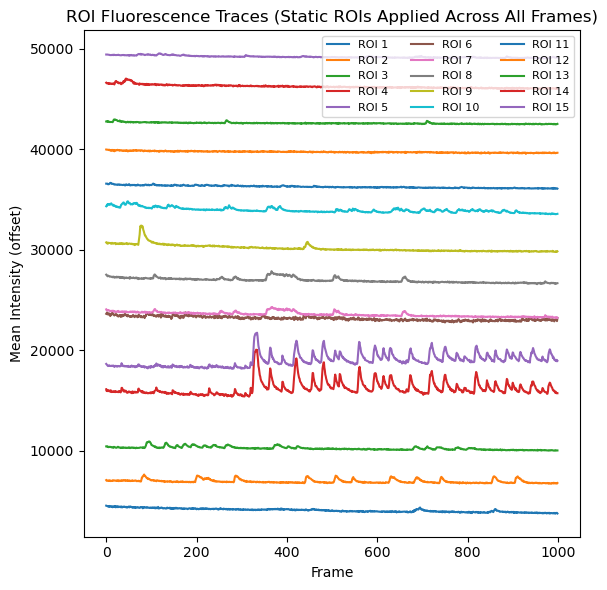

In [25]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from pathlib import Path

# =============================================================================
# 0. ASSUMPTIONS (VERY IMPORTANT)
# =============================================================================
# ✔ You have a LABELS TIFF saved from Napari:
roi_path = Path("/Volumes/Manny4TBUM/12_3_2025/roi_masks_uint16.tif")

# ✔ You have already loaded OR created the motion-corrected movie:
#    mc_movie_u16 must be uint16, shape (T, Y, X)
#    If not loaded yet, load like:
#    mc_movie_u16 = tiff.imread("/path/to/mc_movie_uint16.tif")

# =============================================================================
# 1. LOAD ROI MASK TIFF
# =============================================================================
roi_data = tiff.imread(roi_path)

print("📁 Loaded ROI mask:", roi_path)
print("📐 ROI shape:", roi_data.shape)
print("🔢 ROI dtype:", roi_data.dtype)

unique_vals = np.unique(roi_data)
print("🏷 Unique labels in ROI file:", unique_vals)

roi_ids = unique_vals[unique_vals != 0]  # exclude background (0)
print("🎯 ROI IDs detected:", roi_ids.tolist())

# =============================================================================
# 2. SANITY CHECKS — ROI mask must align with movie dimensions
# =============================================================================
print("\n--- Sanity Check ---")

if roi_data.ndim != 3:
    raise ValueError("ROI mask must be 3D (T, Y, X). Your mask is 2D.")

T_roi, Y_roi, X_roi = roi_data.shape
T_mc, Y_mc, X_mc = mc_movie_u16.shape

print(f"ROI shape:   (T={T_roi}, Y={Y_roi}, X={X_roi})")
print(f"Movie shape: (T={T_mc}, Y={Y_mc}, X={X_mc})")

# Check spatial match
if (Y_roi != Y_mc) or (X_roi != X_mc):
    raise ValueError("ERROR: ROI (Y,X) does NOT match movie size!")

# Check time match
if T_roi != T_mc:
    print("⚠️ WARNING: ROI T != Movie T — Will broadcast ROI mask across time.")
    roi_data = np.broadcast_to(roi_data[0], mc_movie_u16.shape)

print("Sanity check passed ✔\n")

# =============================================================================
# 3. STATIC ROI LOGIC (THIS IS YOUR DESIRED BEHAVIOR)
# =============================================================================
# RULE:
# If an ROI appears on ANY FRAME, treat it as a valid static ROI for ALL frames.
# That means we collapse across time using max() to get a single 2D label map.
static_labels = roi_data.max(axis=0)   # shape (Y, X)

print("Static ROI map created. Unique labels:", np.unique(static_labels))

# =============================================================================
# 4. EXTRACT TRACES USING STATIC ROIs
# =============================================================================
def extract_static_traces(mc_movie, static_labels):
    """
    mc_movie:      (T, Y, X), uint16 motion-corrected movie
    static_labels: (Y, X) ROI mask collapsed across time
    Output: dict {roi_id: trace (length T)}
    """
    roi_ids = np.unique(static_labels)
    roi_ids = roi_ids[roi_ids != 0]  # skip background

    traces = {}
    for rid in roi_ids:
        mask = (static_labels == rid)         # (Y,X)
        trace = mc_movie[:, mask].mean(axis=1)  # intensity over time
        traces[rid] = trace
    return traces

traces = extract_static_traces(mc_movie_u16, static_labels)
print("Extracted traces for ROIs:", list(traces.keys()))

# =============================================================================
# 5. PLOT ALL TRACES STACKED
# =============================================================================
plt.figure(figsize=(6, 6))

offset = 0
spacing = np.max(mc_movie_u16) * 0.05   # vertical spacing between traces

for rid in sorted(traces.keys()):
    plt.plot(traces[rid] + offset, label=f"ROI {rid}")
    offset += spacing

plt.title("ROI Fluorescence Traces (Static ROIs Applied Across All Frames)")
plt.xlabel("Frame")
plt.ylabel("Mean Intensity (offset)")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

In [38]:
from pathlib import Path
import numpy as np
import tifffile as tiff

def report_roi_specs(roi_path, mc_movie_u16=None, strict=False):
    """
    Read-only spec reporter for ROI labels.
    - Does NOT modify data
    - Does NOT broadcast or reindex
    """
    roi_path = Path(roi_path)
    roi = tiff.imread(roi_path)

    unique = np.unique(roi)
    roi_ids = unique[unique != 0]

    print("📁 ROI path:", roi_path)
    print("📐 ROI shape:", roi.shape)
    print("🔢 ROI dtype:", roi.dtype)
    print("🏷 Unique labels:", unique)
    print("🎯 ROI IDs (nonzero):", roi_ids.tolist())

    if roi.ndim == 3:
        print("🧭 Axis order assumed: (T, Y, X)")
    elif roi.ndim == 2:
        print("🧭 Axis order assumed: (Y, X)")
    else:
        msg = f"ROI must be 2D or 3D, got shape {roi.shape}"
        if strict:
            raise ValueError(msg)
        print("⚠️", msg)

    if mc_movie_u16 is not None:
        print("\n--- Sanity Check ---")
        print("Movie shape:", mc_movie_u16.shape)

        if roi.ndim == 3:
            if roi.shape[1:] != mc_movie_u16.shape[1:]:
                msg = f"ROI (Y,X) {roi.shape[1:]} != Movie (Y,X) {mc_movie_u16.shape[1:]}"
                if strict:
                    raise ValueError(msg)
                print("⚠️", msg)
            if roi.shape[0] != mc_movie_u16.shape[0]:
                msg = f"ROI T {roi.shape[0]} != Movie T {mc_movie_u16.shape[0]}"
                if strict:
                    raise ValueError(msg)
                print("⚠️", msg)

        if roi.ndim == 2:
            if roi.shape != mc_movie_u16.shape[1:]:
                msg = f"ROI (Y,X) {roi.shape} != Movie (Y,X) {mc_movie_u16.shape[1:]}"
                if strict:
                    raise ValueError(msg)
                print("⚠️", msg)

    return {
        "path": str(roi_path),
        "shape": roi.shape,
        "dtype": str(roi.dtype),
        "unique_labels": unique,
        "roi_ids": roi_ids,
    }

# Usage:
specs = report_roi_specs("/Volumes/Manny4TBUM/12_3_2025/roi_masks_uint16.tif", mc_movie_u16, strict=False)


📁 ROI path: /Volumes/Manny4TBUM/12_3_2025/roi_masks_uint16.tif
📐 ROI shape: (1000, 512, 512)
🔢 ROI dtype: uint16
🏷 Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
🎯 ROI IDs (nonzero): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
🧭 Axis order assumed: (T, Y, X)

--- Sanity Check ---
Movie shape: (1000, 512, 512)


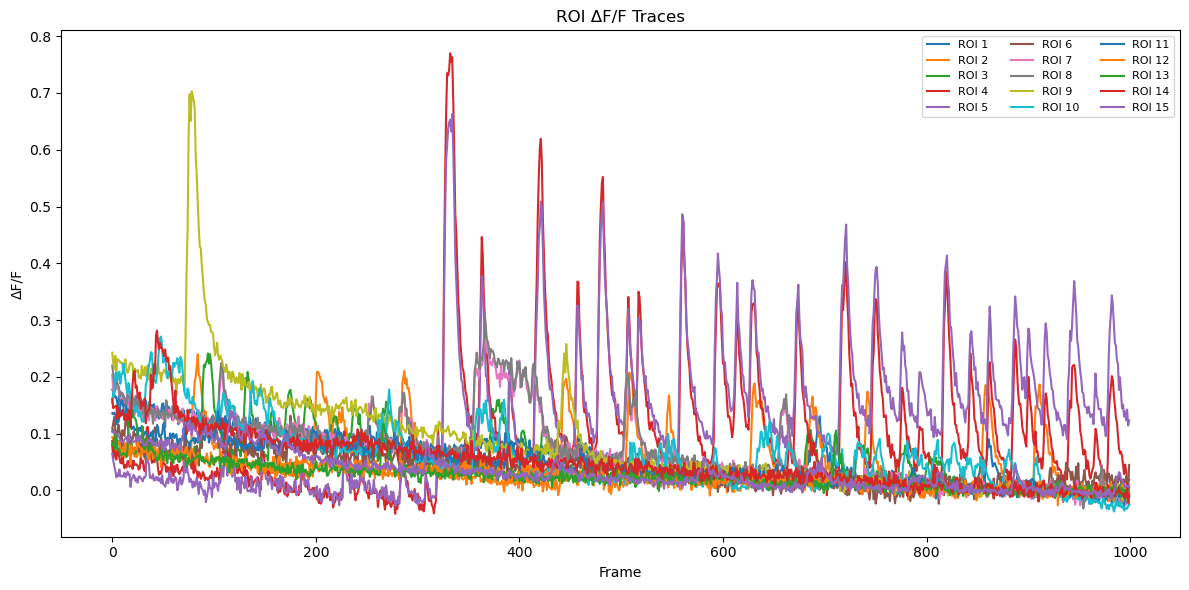

In [26]:
def compute_dff(trace, baseline_percentile=10):
    f0 = np.percentile(trace, baseline_percentile)
    dff = (trace - f0) / (f0 + 1e-9)
    return dff

# Compute ΔF/F for all ROIs
dff_traces = {rid: compute_dff(trace) for rid, trace in traces.items()}

plt.figure(figsize=(12,6))

for rid in sorted(dff_traces.keys()):
    plt.plot(dff_traces[rid], label=f"ROI {rid}")

plt.title("ROI ΔF/F Traces")
plt.xlabel("Frame")
plt.ylabel("ΔF/F")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

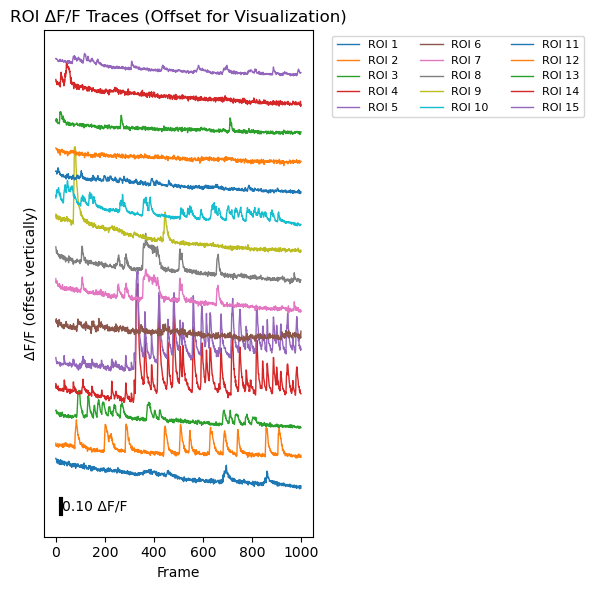

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# dff_traces = {roi_id: df_over_f_vector}

# ------------------------
# CONFIGURATION
# ------------------------
offset_step = 0.2     # vertical spacing between traces (ΔF/F units)
scale_bar_height = 0.1  # what the scale bar should represent in ΔF/F
scale_bar_x = 20        # x-position of scale bar
scale_bar_y = -0.2      # y-position relative to the lowest trace

# ------------------------
# BUILD THE PLOT
# ------------------------
plt.figure(figsize=(6, 6))
sorted_ids = sorted(dff_traces.keys())

# Compute the baseline offset for each trace
offsets = np.arange(len(sorted_ids)) * offset_step

for i, rid in enumerate(sorted_ids):
    plt.plot(dff_traces[rid] + offsets[i], label=f"ROI {rid}", linewidth=1)

# ------------------------
# SCALE BAR
# ------------------------
# Draw a vertical bar with the chosen ΔF/F magnitude
plt.plot([scale_bar_x, scale_bar_x],
         [scale_bar_y, scale_bar_y + scale_bar_height],
         color='black', linewidth=3)

plt.text(scale_bar_x + 5,
         scale_bar_y + scale_bar_height / 2,
         f"{scale_bar_height:.2f} ΔF/F",
         va='center')

# ------------------------
# STYLING
# ------------------------
plt.xlabel("Frame")
plt.ylabel("ΔF/F (offset vertically)")
plt.title("ROI ΔF/F Traces (Offset for Visualization)")
plt.yticks([])  # hides absolute y-axis since offsets break absolute scale
plt.legend(ncol=3, fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from pathlib import Path

def make_mc_roi_trace_movie(mc_movie_u16, static_labels, dff_traces, video_path,
                            fps=10, cmap='gray'):
    """
    Creates a 3-panel movie similar to your previous MP4 generator:
    LEFT: motion-corrected movie
    MIDDLE: movie with ROI colored overlay
    RIGHT: ΔF/F trace panel with moving vertical cursor

    Saves the MP4 in the same directory as the given video_path.
    """

    # -------------------------------------------------------------
    # WHERE TO SAVE OUTPUT
    # -------------------------------------------------------------
    video_path = Path(video_path)
    save_dir = video_path.parent
    out_path = save_dir / f"{video_path.stem}_MC_ROI_TRACE.mp4"

    # -------------------------------------------------------------
    # DATA PREP
    # -------------------------------------------------------------
    T, Y, X = mc_movie_u16.shape

    # normalize movie
    lo, hi = np.percentile(mc_movie_u16, [1, 99])
    def norm(frame):
        return np.clip((frame - lo)/(hi-lo+1e-9), 0, 1)

    # ROI overlay colors
    roi_ids = sorted([rid for rid in np.unique(static_labels) if rid != 0])
    roi_cmap = plt.colormaps.get_cmap("tab20")

    # build static ROI color map (RGB)
    roi_rgb = np.zeros((Y, X, 3), dtype=np.float32)
    for idx, rid in enumerate(roi_ids):
        roi_rgb[static_labels == rid] = roi_cmap(idx)[:3]

    # prepare DFF y-axis limits
    ymax = max([dff_traces[r].max() for r in roi_ids]) * 1.1
    ymin = -0.02

    # -------------------------------------------------------------
    # START MP4 WRITER
    # -------------------------------------------------------------
    writer = imageio.get_writer(str(out_path), fps=fps, codec='libx264')

    # -------------------------------------------------------------
    # FRAME LOOP
    # -------------------------------------------------------------
    for t in range(T):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # ----------------------
        # Panel 1: MC MOVIE
        # ----------------------
        axes[0].imshow(norm(mc_movie_u16[t]), cmap=cmap)
        axes[0].set_title("Motion-Corrected")
        axes[0].axis("off")

        # ----------------------
        # Panel 2: ROI Overlay
        # ----------------------
        base = plt.colormaps.get_cmap("gray")(norm(mc_movie_u16[t]))[..., :3]
        overlay = 0.7 * base + 0.3 * roi_rgb
        axes[1].imshow(overlay)
        axes[1].set_title("ROI Overlay")
        axes[1].axis("off")

        # ----------------------
        # Panel 3: ΔF/F Traces
        # ----------------------
        for rid in roi_ids:
            axes[2].plot(dff_traces[rid], linewidth=0.7)

        axes[2].axvline(t, color="black", linewidth=2)
        axes[2].set_ylim([ymin, ymax])
        axes[2].set_title("ΔF/F Traces")
        axes[2].set_xlabel("Frame")

        # ----------------------
        # Convert FIGURE → RGB frame (backend-safe)
        # ----------------------
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())  # (H, W, 4)
        frame = frame[..., :3]                        # strip alpha
        writer.append_data(frame)

        plt.close(fig)

    writer.close()
    print("✔ Saved movie:", out_path)
    return out_path

In [29]:
new_movie = make_mc_roi_trace_movie(
    mc_movie_u16,
    static_labels,
    dff_traces,
    video_path  # path of your prior raw_vs_mc_withtext.mp4
)
new_movie

✔ Saved movie: /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MC_ROI_TRACE.mp4


PosixPath('/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MC_ROI_TRACE.mp4')

In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from pathlib import Path

def make_mc_roi_trace_movie_growing(mc_movie_u16, static_labels, dff_traces, video_path,
                                    fps=10, cmap='gray'):
    """
    VERSION 2:
    ΔF/F traces grow dynamically over time (no moving black line).
    """

    # -------------------------------------------------------------
    # WHERE TO SAVE OUTPUT
    # -------------------------------------------------------------
    video_path = Path(video_path)
    save_dir = video_path.parent
    out_path = save_dir / f"{video_path.stem}_MC_ROI_TRACE_GROWING.mp4"

    # -------------------------------------------------------------
    # DATA PREP
    # -------------------------------------------------------------
    T, Y, X = mc_movie_u16.shape

    # normalize movie
    lo, hi = np.percentile(mc_movie_u16, [1, 99])
    def norm(frame):
        return np.clip((frame - lo)/(hi-lo+1e-9), 0, 1)

    # ROI overlay colors
    roi_ids = sorted([rid for rid in np.unique(static_labels) if rid != 0])
    roi_cmap = plt.colormaps.get_cmap("tab20")

    # static ROI coloring
    roi_rgb = np.zeros((Y, X, 3), dtype=np.float32)
    for idx, rid in enumerate(roi_ids):
        roi_rgb[static_labels == rid] = roi_cmap(idx)[:3]

    # ΔF/F y-limits
    ymax = max([dff_traces[r].max() for r in roi_ids]) * 1.1
    ymin = min([dff_traces[r].min() for r in roi_ids]) * 1.1

    # -------------------------------------------------------------
    # START MOVIE
    # -------------------------------------------------------------
    writer = imageio.get_writer(str(out_path), fps=fps, codec='libx264')

    for t in range(T):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # ----------------------
        # Panel 1: MC movie
        # ----------------------
        axes[0].imshow(norm(mc_movie_u16[t]), cmap=cmap)
        axes[0].set_title("Motion-Corrected")
        axes[0].axis("off")

        # ----------------------
        # Panel 2: ROI overlay
        # ----------------------
        base = plt.colormaps.get_cmap("gray")(norm(mc_movie_u16[t]))[..., :3]
        overlay = 0.7 * base + 0.3 * roi_rgb
        axes[1].imshow(overlay)
        axes[1].set_title("ROI Overlay")
        axes[1].axis("off")

        # ----------------------
        # Panel 3: ΔF/F traces (growing over time)
        # ----------------------
        for rid in roi_ids:
            axes[2].plot(dff_traces[rid][:t+1], linewidth=0.7)

        axes[2].set_xlim([0, T])
        axes[2].set_ylim([ymin, ymax])
        axes[2].set_title("ΔF/F Traces (Growing)")
        axes[2].set_xlabel("Frame")

        # Render → array
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        writer.append_data(frame)
        plt.close(fig)

    writer.close()
    print("✔ Saved movie:", out_path)
    return out_path

In [ ]:
growing_movie = make_mc_roi_trace_movie_growing(
    mc_movie_u16,
    static_labels,
    dff_traces,
    video_path
)

growing_movie

In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import math

def make_mc_roi_trace_movie_grid(
    mc_movie_u16,
    static_labels,
    dff_traces,
    video_path,
    fps=10,
    cmap='gray',
    n_cols=5,
    inset_pad=5
):
    """
    Creates a movie with:
    - MC movie
    - ROI overlay
    - Global growing ΔF/F
    - Grid of ROI-specific growing traces + dynamic inset patch
    """

    # ---------------- SAVE PATH ----------------
    video_path = Path(video_path)
    save_dir = video_path.parent
    out_path = save_dir / f"{video_path.stem}_MC_ROI_TRACE_GRID.mp4"

    # ---------------- PREP DATA ----------------
    T, Y, X = mc_movie_u16.shape

    lo, hi = np.percentile(mc_movie_u16, [1, 99])
    def norm(frame):
        return np.clip((frame - lo)/(hi-lo+1e-9), 0, 1)

    roi_ids = sorted([rid for rid in np.unique(static_labels) if rid != 0])
    n_rois = len(roi_ids)

    roi_cmap = plt.colormaps.get_cmap("tab20")

    # ROI static overlay (color mask)
    roi_rgb = np.zeros((Y, X, 3), dtype=np.float32)
    for i, rid in enumerate(roi_ids):
        roi_rgb[static_labels == rid] = roi_cmap(i)[:3]

    # y-limits for ΔF/F
    global_ymax = max(dff_traces[r].max() for r in roi_ids) * 1.1
    global_ymin = min(dff_traces[r].min() for r in roi_ids) * 1.1

    # grid size
    n_rows = math.ceil(n_rois / n_cols)

    # ---------------- START WRITER ----------------
    writer = imageio.get_writer(str(out_path), fps=fps, codec="libx264")

    # ---------------- FRAME LOOP ----------------
    for t in range(T):

        fig = plt.figure(figsize=(16, 10))

        # -------- TOP ROW GRID (1×3) --------
        gs_top = fig.add_gridspec(1, 3, top=0.92, bottom=0.65, hspace=0.3)

        # Panel 1
        ax1 = fig.add_subplot(gs_top[0, 0])
        ax1.imshow(norm(mc_movie_u16[t]), cmap=cmap)
        ax1.set_title("Motion-Corrected")
        ax1.axis("off")

        # Panel 2
        ax2 = fig.add_subplot(gs_top[0, 1])
        base = plt.colormaps.get_cmap("gray")(norm(mc_movie_u16[t]))[..., :3]
        overlay = 0.7*base + 0.3*roi_rgb
        ax2.imshow(overlay)
        ax2.set_title("ROI Overlay")
        ax2.axis("off")

        # Panel 3
        ax3 = fig.add_subplot(gs_top[0, 2])
        for rid in roi_ids:
            ax3.plot(dff_traces[rid][:t+1], linewidth=0.7)
        ax3.set_ylim(global_ymin, global_ymax)
        ax3.set_xlim(0, T)
        ax3.set_title("ΔF/F (Growing)")
        ax3.set_xlabel("Frame")

        # -------- ROI GRID (n_rows × n_cols) --------
        gs_grid = fig.add_gridspec(n_rows, n_cols, top=0.62, bottom=0.05, hspace=0.45)

        for i, rid in enumerate(roi_ids):
            r = i // n_cols
            c = i % n_cols
            ax = fig.add_subplot(gs_grid[r, c])

            # growing ΔF/F trace
            ax.plot(dff_traces[rid][:t+1], color=roi_cmap(i)[:3], linewidth=0.8)
            ax.set_xlim(0, T)
            ax.set_ylim(global_ymin, global_ymax)
            ax.set_title(f"ROI {rid}", fontsize=9)

            # dynamic ROI inset
            ys, xs = np.where(static_labels == rid)
            if len(xs) > 0:
                y0, y1 = max(0, ys.min()-inset_pad), min(Y, ys.max()+inset_pad)
                x0, x1 = max(0, xs.min()-inset_pad), min(X, xs.max()+inset_pad)

                inset = norm(mc_movie_u16[t, y0:y1, x0:x1])
                ax_in = ax.inset_axes([0.65, 0.55, 0.3, 0.35])
                ax_in.imshow(inset, cmap=cmap)
                ax_in.set_xticks([])
                ax_in.set_yticks([])

        # ---------------- SAVE FRAME ----------------
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba(), dtype=np.uint8)[..., :3]
        writer.append_data(frame)
        plt.close(fig)

    writer.close()
    print("✔ Saved GRID movie:", out_path)
    return out_path

In [ ]:
grid_movie = make_mc_roi_trace_movie_grid(
    mc_movie_u16,
    static_labels,
    dff_traces,
    video_path,
    fps=10,
    n_cols=5
)
grid_movie

In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import math
from skimage.measure import find_contours

def make_mc_roi_trace_movie_grid_with_outlines(
    mc_movie_u16,
    static_labels,
    dff_traces,
    video_path,
    fps=10,
    cmap='gray',
    n_cols=5,
    inset_pad=5
):
    """
    Creates a high-detail ROI-grid movie with:
    - Motion-corrected movie (top-left)
    - ROI overlay (top-middle)
    - Global ΔF/F (growing)
    - Grid of ROIs with:
        * Growing ΔF/F trace
        * ROI ID label
        * Dynamic inset image of ROI crop
        * Colored ROI boundary outline

    Saves MP4 in the same directory as the given video_path.
    """

    # -------------------------------------------------------------
    # WHERE TO SAVE OUTPUT
    # -------------------------------------------------------------
    video_path = Path(video_path)
    save_dir = video_path.parent
    out_path = save_dir / f"{video_path.stem}_MC_ROI_TRACE_GRID_OUTLINES.mp4"

    # -------------------------------------------------------------
    # PREPARE DATA
    # -------------------------------------------------------------
    T, Y, X = mc_movie_u16.shape

    lo, hi = np.percentile(mc_movie_u16, [1, 99])
    def norm(frame):
        return np.clip((frame - lo)/(hi-lo+1e-9), 0, 1)

    roi_ids = sorted([rid for rid in np.unique(static_labels) if rid != 0])
    n_rois = len(roi_ids)

    roi_cmap = plt.colormaps.get_cmap("tab20")

    # Make overlay colors for MC frame
    roi_rgb = np.zeros((Y, X, 3), dtype=np.float32)
    for i, rid in enumerate(roi_ids):
        roi_rgb[static_labels == rid] = roi_cmap(i)[:3]

    # y-limits for ΔF/F
    global_ymax = max(dff_traces[r].max() for r in roi_ids) * 1.1
    global_ymin = min(dff_traces[r].min() for r in roi_ids) * 1.1

    # grid size
    n_rows = math.ceil(n_rois / n_cols)

    # -------------------------------------------------------------
    # PRECOMPUTE ROI BOUND BOXES FOR SPEED
    # -------------------------------------------------------------
    roi_bounds = {}
    for i, rid in enumerate(roi_ids):
        ys, xs = np.where(static_labels == rid)
        if len(xs) > 0:
            y0 = max(0, ys.min() - inset_pad)
            y1 = min(Y, ys.max() + inset_pad)
            x0 = max(0, xs.min() - inset_pad)
            x1 = min(X, xs.max() + inset_pad)
            roi_bounds[rid] = (y0, y1, x0, x1)
        else:
            roi_bounds[rid] = None

    # -------------------------------------------------------------
    # START FRAMED MOVIE
    # -------------------------------------------------------------
    writer = imageio.get_writer(str(out_path), fps=fps, codec="libx264")

    for t in range(T):

        fig = plt.figure(figsize=(16, 10))

        # -------- TOP ROW GRID (1×3) --------
        gs_top = fig.add_gridspec(1, 3, top=0.92, bottom=0.65, hspace=0.25)

        # Panel 1: Motion-corrected
        ax1 = fig.add_subplot(gs_top[0, 0])
        ax1.imshow(norm(mc_movie_u16[t]), cmap=cmap)
        ax1.set_title("Motion-Corrected")
        ax1.axis("off")

        # Panel 2: ROI Overlay
        ax2 = fig.add_subplot(gs_top[0, 1])
        base = plt.colormaps.get_cmap("gray")(norm(mc_movie_u16[t]))[..., :3]
        overlay = 0.7*base + 0.3*roi_rgb
        ax2.imshow(overlay)
        ax2.set_title("ROI Overlay")
        ax2.axis("off")

        # Panel 3: Global ΔF/F growing
        ax3 = fig.add_subplot(gs_top[0, 2])
        for rid in roi_ids:
            ax3.plot(dff_traces[rid][:t+1], linewidth=0.7)
        ax3.set_ylim(global_ymin, global_ymax)
        ax3.set_xlim(0, T)
        ax3.set_title("ΔF/F (Growing)")
        ax3.set_xlabel("Frame")

        # -------- ROI GRID (n_rows × n_cols) --------
        gs_grid = fig.add_gridspec(n_rows, n_cols, top=0.62, bottom=0.05, hspace=0.55)

        for i, rid in enumerate(roi_ids):
            r = i // n_cols
            c = i % n_cols
            ax = fig.add_subplot(gs_grid[r, c])

            # ROI ΔF/F trace (growing)
            ax.plot(dff_traces[rid][:t+1], color=roi_cmap(i)[:3], linewidth=0.8)
            ax.set_xlim(0, T)
            ax.set_ylim(global_ymin, global_ymax)
            ax.set_title(f"ROI {rid}", fontsize=9)

            # ------- ROI INSET WITH OUTLINE -------
            bounds = roi_bounds[rid]
            if bounds is not None:
                y0, y1, x0, x1 = bounds

                # dynamic crop
                inset_frame = norm(mc_movie_u16[t, y0:y1, x0:x1])

                # create inset axes
                ax_in = ax.inset_axes([0.65, 0.55, 0.3, 0.35])
                ax_in.imshow(inset_frame, cmap=cmap)
                ax_in.set_xticks([])
                ax_in.set_yticks([])

                # MASK crop for boundary detection
                roi_crop = (static_labels[y0:y1, x0:x1] == rid)

                # find contours
                contours = find_contours(roi_crop.astype(float), 0.5)

                # draw outline(s)
                for contour in contours:
                    ax_in.plot(
                        contour[:, 1], contour[:, 0],
                        color=roi_cmap(i)[:3],
                        linewidth=1.5
                    )

        # -------- SAVE FRAME --------
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba(), dtype=np.uint8)[..., :3]
        writer.append_data(frame)
        plt.close(fig)

    writer.close()
    print("✔ Saved GRID movie with OUTLINES:", out_path)
    return out_path

In [ ]:
movie_with_outlines = make_mc_roi_trace_movie_grid_with_outlines(
    mc_movie_u16,
    static_labels,
    dff_traces,
    video_path,    # SAME logic: save next to this movie
    fps=10,
    n_cols=5
)

movie_with_outlines

In [12]:
import subprocess
import sys
from pathlib import Path
import json

def launch_roi_editor_subprocess(movie_path):
    """
    Fully robust Napari ROI editor launcher (subprocess safe).
    Features:
      • Auto-load movie
      • Auto-load or compute MAX projection
      • Auto-load or create roi_masks.npy
      • Atomic autosave of ROI mask
      • Live ROI count, ID list, pixel counts
      • On-screen overlay (no position assignment needed)
      • Napari status bar updates
      • Works even when Napari is unstable in Jupyter
    """

    movie_path = Path(movie_path)
    parent = movie_path.parent
    stem = movie_path.stem.replace("_MCMOVIE_uint16", "")

    args = {
        "movie_path": str(movie_path),
        "maxproj_path": str(parent / (stem + "_MAXPROJ.tif")),
        "roi_npy_path": str(parent / (stem + "_roi_masks.npy")),
    }

    # =====================================================================
    # IMPORTANT: All braces inside THIS string must be escaped as {{ }}
    # =====================================================================
    code = f"""
import numpy as np
import tifffile as tiff
import napari
from pathlib import Path
import os
import json

# ----------------------------
# LOAD ARGUMENTS
# ----------------------------
args = json.loads('''{json.dumps(args)}''')

movie_path = Path(args["movie_path"])
maxproj_path = Path(args["maxproj_path"])
roi_npy_path = Path(args["roi_npy_path"])

print("MOVIE:", movie_path)
print("ROI FILE:", roi_npy_path)
print("MAXPROJ:", maxproj_path)

# ----------------------------
# LOAD MOVIE
# ----------------------------
movie = tiff.imread(movie_path)
T, Y, X = movie.shape
print("Movie loaded:", movie.shape)

# ----------------------------
# LOAD OR COMPUTE MAX PROJECTION
# ----------------------------
if maxproj_path.exists():
    maxproj = tiff.imread(maxproj_path)
else:
    print("MAXPROJ missing — computing.")
    maxproj = movie.max(axis=0)
    tiff.imwrite(maxproj_path, maxproj.astype("float32"))
print("MAXPROJ ready.")

# ----------------------------
# LOAD OR CREATE ROI MASK (.npy)
# ----------------------------
if roi_npy_path.exists():
    roi_data = np.load(roi_npy_path)
    if roi_data.shape != (T, Y, X):
        print("ROI mask shape mismatch — creating empty new mask.")
        roi_data = np.zeros((T, Y, X), dtype=np.uint16)
else:
    print("No ROI mask found — creating new empty mask.")
    roi_data = np.zeros((T, Y, X), dtype=np.uint16)
    np.save(roi_npy_path, roi_data)

print("ROI mask loaded. Unique labels:", np.unique(roi_data))

# ----------------------------
# LAUNCH NAPARI
# ----------------------------
viewer = napari.Viewer()
viewer.add_image(movie, name="raw_movie")
viewer.add_image(maxproj, name="max_projection")

# Create editable labels layer
labels_layer = viewer.add_labels(roi_data, name="roi_masks")

# Configure overlay (without setting .position → avoids ValidationError)
viewer.text_overlay.visible = True
viewer.text_overlay.font_size = 16
viewer.text_overlay.color = "yellow"

# ----------------------------
# AUTOSAVE + LIVE FEEDBACK
# ----------------------------
def autosave_and_report(event):
    data = labels_layer.data

    # ----- Atomic save -----
    tmp = str(roi_npy_path) + ".tmp"
    np.save(tmp, data)
    os.replace(tmp, roi_npy_path)

    # ----- Compute ROI statistics -----
    uniq, counts = np.unique(data, return_counts=True)
    roi_ids = uniq[uniq != 0]      # exclude background
    roi_counts = counts[uniq != 0]

    # Build pixel stats safely (no f-strings)
    pixel_list = []
    for rid, pix in zip(roi_ids, roi_counts):
        pixel_list.append(str(rid) + ":" + str(pix))
    pixel_str = ", ".join(pixel_list)

    # ----- Update status bar -----
    viewer.status = (
        "ROIs: " + str(len(roi_ids)) +
        " — IDs: " + str(list(roi_ids)) +
        " — pixels: [" + pixel_str + "]"
    )

    # ----- Update on-screen overlay -----
    viewer.text_overlay.text = (
        "ROI SUMMARY\\n"
        "Total: " + str(len(roi_ids)) + "\\n"
        "IDs: " + str(list(roi_ids)) + "\\n"
        "Pixels: [" + pixel_str + "]"
    )

    # ----- Print to console (in subprocess) -----
    print("\\n-----------------------------")
    print("ROI MASK SAVED:", roi_npy_path)
    print("Total ROIs:", len(roi_ids))
    print("ROI IDs:", list(roi_ids))
    print("Pixels:", pixel_str)
    print("-----------------------------\\n")

labels_layer.events.data.connect(autosave_and_report)

print("Napari ready — edit ROIs freely.")
print("Autosaving to:", roi_npy_path)

napari.run()
"""

    # ----------------------------
    # LAUNCH NAPARI SUBPROCESS
    # ----------------------------
    subprocess.Popen([sys.executable, "-c", code])
    print("Napari launched in a separate process.")

In [13]:
launch_roi_editor_subprocess(
    "/Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MCMOVIE_uint16.tif"
)

Napari launched in a separate process.


MOVIE: /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MCMOVIE_uint16.tif
ROI FILE: /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_roi_masks.npy
MAXPROJ: /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_MAXPROJ.tif
Movie loaded: (1000, 512, 512)
MAXPROJ ready.
ROI mask loaded. Unique labels: [0]
Napari ready — edit ROIs freely.
Autosaving to: /Volumes/Manny4TBUM/12_3_2025/test_gcamp_dreadd_dtom_Confocal - Green_2025-12-03_2_raw_vs_mc_withtext_roi_masks.npy


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
